# Steps
1. Load data
2. Preprocess
3. TFIDF


_______
## 1. Imports/ Load Data

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot

In [5]:
df = pd.read_csv('data/JEOPARDY_CSV.csv', date_parser=[' Air Date'])

In [8]:
new_cols = {s:s.strip() for s in df.columns}
df = df.rename(columns=new_cols)

In [9]:
def has_link(cell):
    if '<a' in cell and 'a>' in cell:
        return True
        #link_text = cell[cell.index('<a'):cell.index('a>') + 2]
       # return cell.replace(link_text, '')
    else:
        return False
        

In [10]:
df['Has Link'] = df['Question'].apply(lambda x: has_link(x))

In [11]:
# For things without answers, we can drop
reduced_df = df.dropna()
df.shape, reduced_df.shape

((216930, 8), (216928, 8))

In [12]:
reduced_df['Year'] = reduced_df['Air Date'].apply(lambda x: x.split('-')[0])

<ipython-input-12-47cda06411ea>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_df['Year'] = reduced_df['Air Date'].apply(lambda x: x.split('-')[0])


In [14]:
reduced_df['Text'] = reduced_df['Question'] + ' ' + reduced_df['Answer']

jeopardy_df = reduced_df[reduced_df['Round'] == 'Jeopardy!']


<ipython-input-14-e4766086616b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_df['Text'] = reduced_df['Question'] + ' ' + reduced_df['Answer']


________
## 2. Preprocess

In [22]:
import spacy
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


In [23]:
nlp = spacy.load("en")

def get_noun_chunks(cell):
    doc = nlp(cell)
    
    res = []
    for noun in doc.noun_chunks: # use np instead of np.text
        res.append(str(noun))
    
    return ' '.join(res)
    
def normalize_text(cell):
    # Remove punctuation:
    cell = cell.lower()
    cell = cell.translate(str.maketrans('', '', string.punctuation))
    wordnet_lemmatizer = WordNetLemmatizer()
    token_list = word_tokenize(cell)
    
    return ' '.join([wordnet_lemmatizer.lemmatize(w) for w in token_list if w not in stopwords.words('english')])
    
        

In [24]:
jeopardy_df['Text Nouns'] = jeopardy_df['Text'].apply(lambda x: get_noun_chunks(x))

<ipython-input-24-c044a386913a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jeopardy_df['Text Nouns'] = jeopardy_df['Text'].apply(lambda x: get_noun_chunks(x))


In [25]:
jeopardy_df['Norm Text Nouns'] = jeopardy_df['Text Nouns'].apply(lambda x: normalize_text(x))

<ipython-input-25-967b1d30b092>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jeopardy_df['Norm Text Nouns'] = jeopardy_df['Text Nouns'].apply(lambda x: normalize_text(x))


_______
## Find which k to choose with Coherence scores

In [48]:
from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LdaModel

In [37]:
common_texts = [i.split() for i in jeopardy_df['Norm Text Nouns']]
common_dictionary = Dictionary(common_texts)
common_corpus = [common_dictionary.doc2bow(text) for text in common_texts]

In [ ]:
k_info = {}
for k in range(1,20,4):
    lda = LdaModel(common_corpus, num_topics=k)
    cm = CoherenceModel(model=lda, corpus=common_corpus, dictionary=common_dictionary, coherence='u_mass')
    k_info[k] = cm.get_coherence()

In [52]:
import matplotlib.pyplot as plt

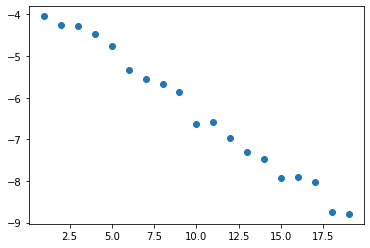

In [55]:
plt.scatter(list(k_info.keys()), list(k_info.values()))

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [ ]:
def is_integer(cell):
    if int(cell) == float(cell):
        return True
    else:
        return False
    
def find_largest_divisor(num):
    res = []
    for i in range(1, num):
        if is_integer(num/i):
            res.append(i)
    return res[len(res)//2], num//res[len(res)//2]

# for topic_idx, topic in enumerate(lda.components_):
def get_top_15(topic_idx, topic, components):
    top_features = []
    for t in topic.argsort()[-15:]:
        if components[topic_idx, t] < 0.5:
            break
        else:
            top_features.append(t)
    return reversed(top_features)


In [ ]:
def plot_top_words(num_topics, X, feature_names, n_top_words, title):
    res = []
    lda = LDA(n_components=num_topics, learning_method='online')
    model = lda.fit(X)
    doc_topic_prob = model.transform(X)
    doc_prob = defaultdict(int)
    for row in doc_topic_prob:
        doc_prob[np.argmax(row)] += 1
    total = len(doc_topic_prob)
    row, col = find_largest_divisor(num_topics)
    fig, axes = plt.subplots(row, col, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = list(get_top_15(topic_idx, topic, model.components_))#topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        prob = 100 * doc_prob[topic_idx]/total
        res.append(prob)
        ax.set_title(f'Topic {topic_idx +1} | {prob:.2f}%',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()
    return res

_____
## 4. Script

In [ ]:
# Choosing topics with Coherence score 

In [ ]:
from collections import defaultdict

In [ ]:
topics = defaultdict(list)
distribution = defaultdict(list)
for year in np.unique(jeopardy_df.Year):
    # 1. Get corpus
    corpus = jeopardy_df[jeopardy_df['Year'] == year]['Norm Text Nouns'].values
    # 2. TFIDF and Vocab
    vectorizer = TfidfVectorizer(stop_words={'english'}, ngram_range=(1,5), max_features=5000, max_df=0.7)
    X = vectorizer.fit_transform(corpus)
    Vocab = {index:word for index, word in enumerate(vectorizer.get_feature_names())}
    # 3. LDA model
    odds = plot_top_words(8, X, Vocab, 15, f"LDA on Year: {year}")
    # 4. append odds
    distribution[year] = odds
    # 4. Get user input for each topic:
    for i in range(8):
        topic = input(f"What topic is topic {i+1}?")
        topics[year].append(topic)